In [15]:
%load_ext autoreload
%autoreload 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
from cwc.src.data import DataLoader
import numpy as np

dataset = DataLoader()
dataset.load_from_mat("cwc/data/D1.mat")

# get basic info about the dataset
print("Loaded Dataset:")
print("\tData shape:", dataset.data.shape)
print("\tIndices shape:", dataset.indices.shape)
print("\tClasses shape:", dataset.classes.shape)
print("\tUnique classes:", np.unique(dataset.classes))
print("\tClass instances:", np.bincount(dataset.classes))
print("\tMin distance between spikes:", np.min(np.diff(np.sort(dataset.indices))))


Loaded Dataset:
	Data shape: (1440000,)
	Indices shape: (2176,)
	Classes shape: (2176,)
	Unique classes: [1 2 3 4 5]
	Class instances: [  0 458 441 406 444 427]
	Min distance between spikes: 1


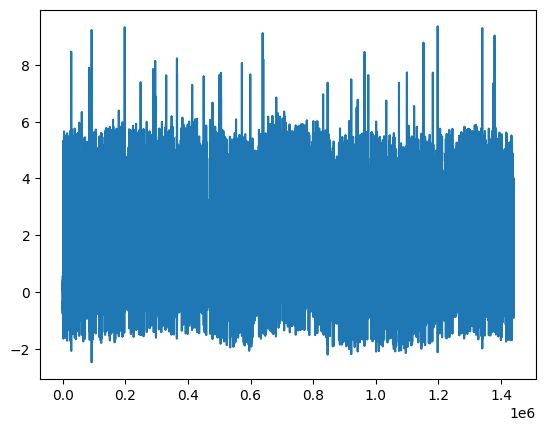

In [17]:
import matplotlib.pyplot as plt

plt.plot(dataset.data)
plt.show()

In [18]:
from cwc.src.data import SignalProcessor

processor = SignalProcessor(dataset)
processor.apply_band_pass_filter(filter_low=300, filter_high=3000, sample_rate=25000, order=4)

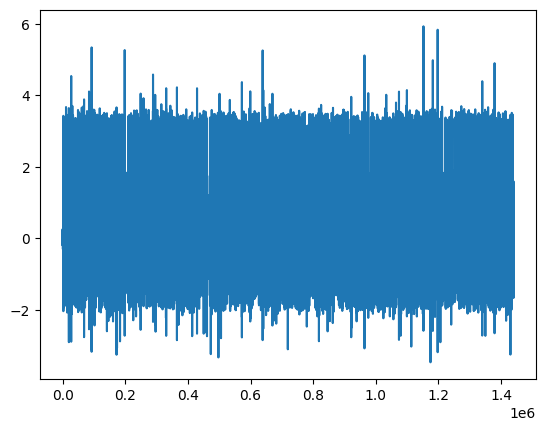

In [19]:
import matplotlib.pyplot as plt

plt.plot(processor.filtered_data)
plt.show()

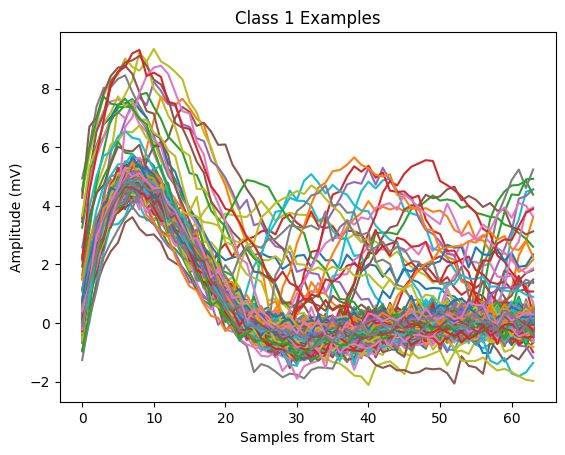

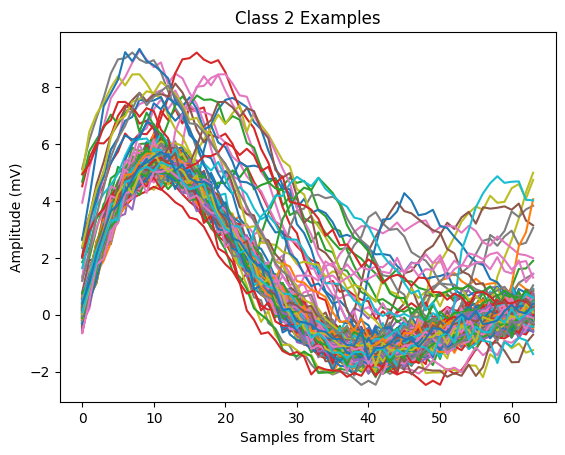

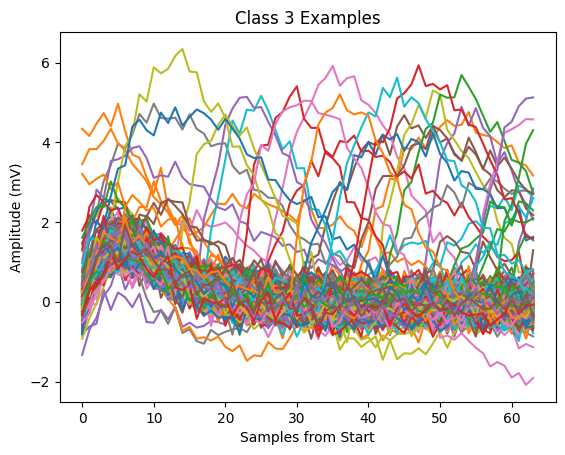

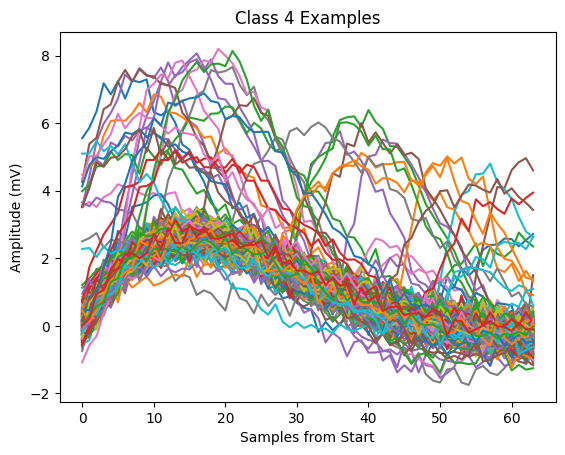

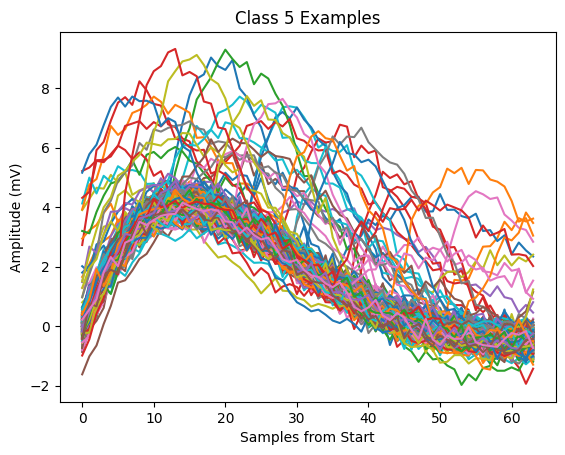

In [20]:
processor.extract_spikes(window_size=64)

# Plot 10 examples per class
classes = dataset.classes
unique_classes = np.unique(classes)

for cls in unique_classes:

    class_indices = np.where(classes == cls)[0] 
    plt.figure() 

    for i in class_indices:
        plt.plot(processor.spikes[i])
        
    plt.title(f'Class {cls} Examples')
    plt.xlabel('Samples from Start')
    plt.ylabel('Amplitude (mV)')
    plt.show()

In [21]:
processor.compute_offsets()

print("Computed Offsets:")
print("\tMean offset:", processor.mean_offset)
print("\tStd offset:", processor.std_offset)
print("\tMin offset:", processor.min_offset)
print("\tMax offset:", processor.max_offset)


Computed Offsets:
	Mean offset: 11.740808823529411
	Std offset: 7.28773824705369
	Min offset: 0
	Max offset: 63


In [ ]:
processor.calculate_mad()

# binary search for mad gain

min_gain = 1.0
max_gain = 20.0

threshold = 0.1
difference = 100

mad_gain = 0.0

while (abs(difference) > threshold):

    mad_gain = (min_gain + max_gain) / 2.0
    processor.detect_spikes(mad_gain=mad_gain, distance=25)

    difference = len(processor.detected_spikes) - len(dataset.indices)

    if difference < 0:
        max_gain = mad_gain
    else:
        min_gain = mad_gain

print(f"\nDetected {len(processor.detected_spikes)} spikes")
print(f"True number of spikes = {len(dataset.indices)} spikes")
print(f"Difference = {len(processor.detected_spikes) - len(dataset.indices)} spikes")
print("Final MAD Gain:", mad_gain)




Detected 2176 spikes
True number of spikes = 2176 spikes
Difference = 0 spikes
